---
title: "Validating and Inspecting Time Series Models"
format:
  html:
    code-fold: true
jupyter: python3
author: "kakamana"
date: "2023-01-27"
categories: [python, datacamp, machine learning, time series ]
image: "validatingTimeSeries.png"

---

# Validating and Inspecting Time Series Models

 Once you've got a model for predicting time series data, you need to decide if it's a good or a bad model. This chapter coves the basics of generating predictions with models in order to validate them against "test" data.

This **Validating and Inspecting Time Series Models** is part of [Datacamp course: Machine Learning for Time Series Data in Python](https://app.datacamp.com/learn/courses/machine-learning-for-time-series-data-in-python)

This is my learning experience of data science through DataCamp

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)
# plt.style.use('fivethirtyeight')
plt.rcParams['image.cmap'] = 'inferno'

## Creating features from the past
- The past is useful
    - Timeseries data almost always have information that is shared between timepoints
    - Information in the past can help predict what happens in the future
    - Often the features best-suited to predict a timeseries are previous values of the same timeseries
- A note on smoothness and auto-correlation
    - A common question to ask of a timeseries: how smooth is the data.
    - AKA, how correlated is a timepoint with its neighboring timepoints (called **autocorrelation**)
    - The amount of auto-correlation in data will impact your models.

### Creating time-shifted features
In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

In this exercise, you'll "shift" your raw data and visualize the results. You'll use the percent change time series that you calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

In [2]:
prices = pd.read_csv('dataset/prices_nyse.csv', index_col=0, parse_dates=True)
prices = prices[['AAPL']]

# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))

    # Calculate a mask for the difference that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)

    # Replace these values with the median across the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)

# Apply your preprocessing functino to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)

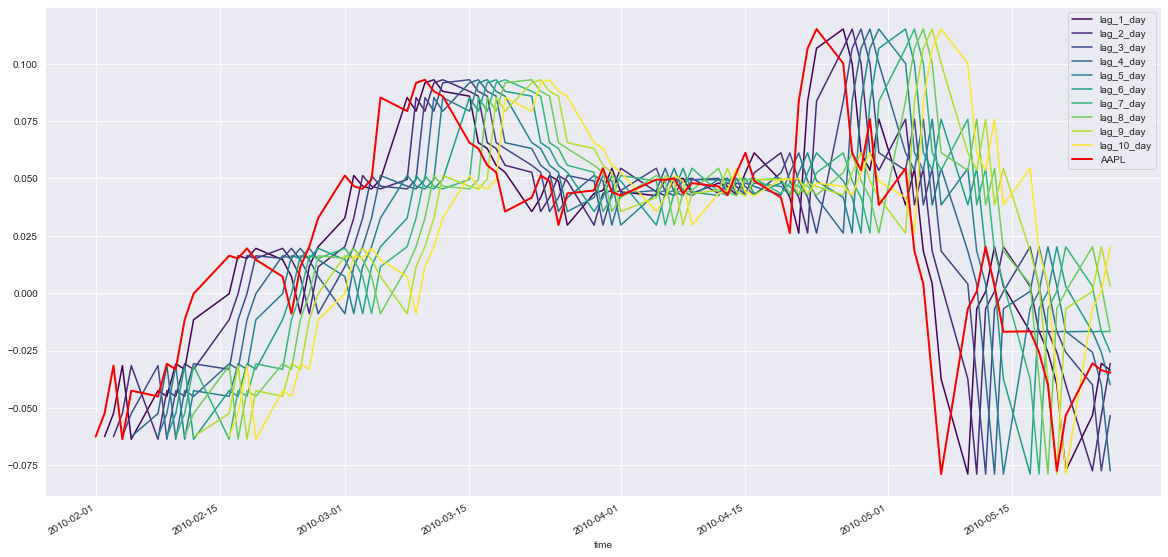

In [3]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift):
                prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
fig, ax = plt.subplots(figsize=(20, 10));
prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis, ax=ax);
prices_perc.iloc[:100].plot(color='r', lw=2, ax=ax);
ax.legend(loc='best');

### Special case: Auto-regressive models
Now that you've created time-shifted versions of a single time series, you can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

In [4]:
from sklearn.linear_model import Ridge

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc['AAPL'].fillna(np.nanmedian(prices_perc['AAPL']))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

### Visualize regression coefficients
Now that you've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.

In this exercise, you will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.


In [5]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs);
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value');

    # set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
    plt.tight_layout();
    return ax

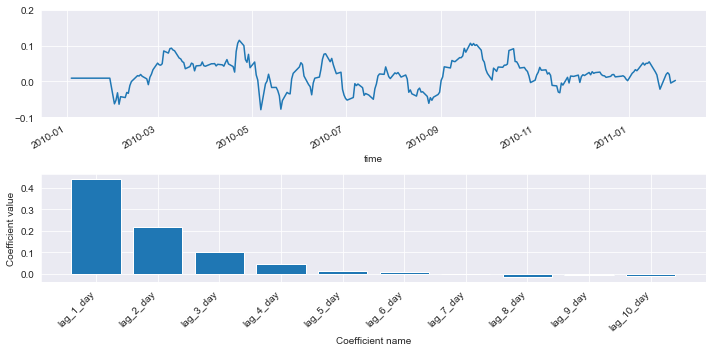

In [6]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0], ylim=(-0.1, 0.2));

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1]);

### Auto-regression with a smoother time series
Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. What do you think this will do to the auto-regressive model?

In [7]:
# Apply your custom function and plot
prices_perc = prices.rolling(40).apply(percent_change)

# Apply your preprocessing functino to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift):
                prices_perc['AAPL'].shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc['AAPL'].fillna(np.nanmedian(prices_perc['AAPL']))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

## Cross-validating time series data


### Cross-validation with shuffling
As you'll recall, cross-validation is the process of splitting your data into training and test sets multiple times. Each time you do this, you choose a different training and test set. In this exercise, you'll perform a traditional ```ShuffleSplit``` cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.

In [8]:
X = pd.read_csv('dataset/x.csv', index_col=0).to_numpy()
y = pd.read_csv('dataset/y.csv', index_col=0).to_numpy()

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression()

In [10]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction,
                       label='Iteration {}'.format(ii))

        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")

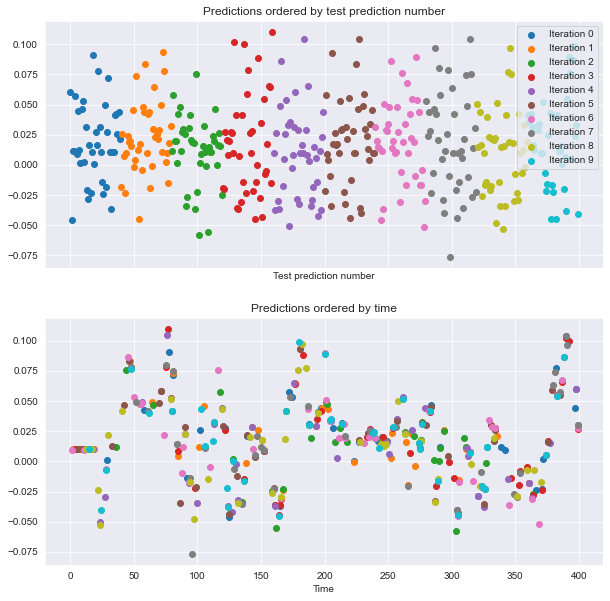

In [11]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, random_state=1)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])

    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X[tt])
    score = r2_score(y[tt], prediction)
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

If you look at the plot to the right, see that the order of datapoints in the test set is scrambled. Let's see how it looks when we shuffle the data in blocks.

### Cross-validation without shuffling
Now, re-run your model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop?

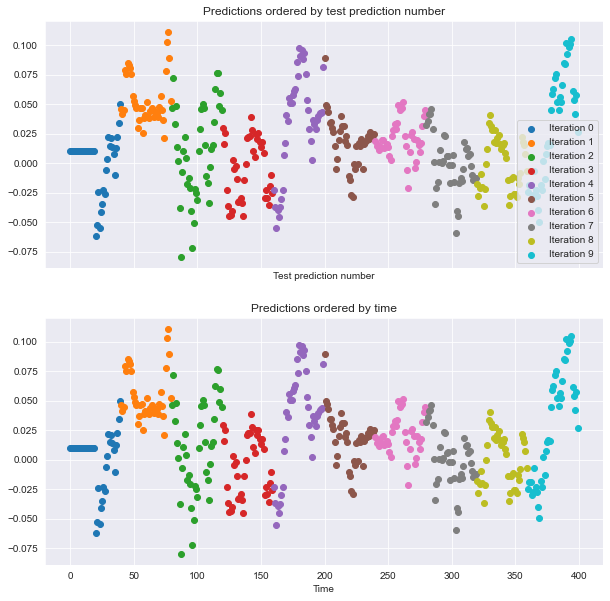

In [12]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False)

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X[tr], y[tr])

    # Generate predictions on the test data and collect
    prediction = model.predict(X[tt])
    results.append((prediction, _, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)

This time, the predictions generated within each CV loop look 'smoother' than they were before - they look more like a real time series because you didn't shuffle the data. This is a good sanity check to make sure your CV splits are correct

### Time-based cross-validation
Finally, let's visualize the behavior of the time series cross-validation iterator in scikit-learn. Use this object to iterate through your data one last time, visualizing the training data used to fit the model on each iteration.

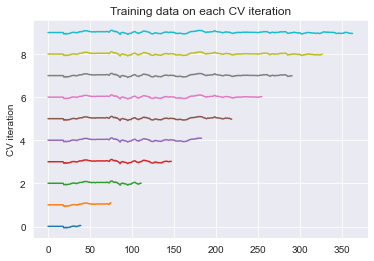

In [13]:
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr]);

ax.set(title='Training data on each CV iteration', ylabel='CV iteration');

Note that the size of the training set grew each time when you used the time series cross-validation object. This way, the time points you predict are always after the timepoints we train on.

## Stationarity and stability
- Stationarity
    - Stationarity time series do not change their statistical properties over time
        - E.g. mean, standard deviation, trends
    - Most time series are non-stationary to some extent
- Model stability
    - Non-stationary data results in variability in our model
    - The statistical properties the model finds may change with the data
    - In addition, we will be less certain about the correct values of model parameters
    - How can we quantify this?
- Cross validation to quantify parameter stability
    - One approach: use cross-validation
    - Calculate model parameters on each iteration
    - Assess parameter stability across all CV splits
- Bootstrapping the mean
    - Bootstrapping is a common way to assess variability
    - The bootstrap:
        1. Take a random sample of data with replacement
        2. Calculate the mean of the sample
        3. Repeat this process many times (1000s)
        4. Calculate the percentiles of the result (usually 2.5, 97.5)
    - The result is a 95% confidence interval of the mean of each coefficient.
- Assessing model performance stability
    - If using the ```TimeSeriesSplit```, can plot the model's score over time
    - This is useful in finding certain regions of time that hurt the score
    - Also useful to find non-stationary signals

### Bootstrapping a confidence interval
A useful tool for assessing the variability of some data is the bootstrap. In this exercise, you'll write your own bootstrapping function that can be used to return a bootstrapped confidence interval.

This function takes three parameters: a 2-D array of numbers (```data```), a list of percentiles to calculate (```percentiles```), and the number of boostrap iterations to use (```n_boots```). It uses the resample function to generate a bootstrap sample, and then repeats this many times to calculate the confidence interval.

In [14]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    # Create our empty array we'll fill with the results
    if data.ndim == 1:
        data = data[:, np.newaxis]
        data = np.atleast_2d(data)
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

### Calculating variability in model coefficients
In this lesson, you'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. You'll investigate the coefficients of the model, as well as the uncertainty in its predictions.

Begin by assessing the stability (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data.

In [15]:
X = pd.read_csv('dataset/stock_12x.csv', index_col=0).to_numpy()
y = pd.read_csv('dataset/stock_12y.csv', index_col=0).to_numpy()

feature_names = np.array(['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day',
       'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day',
       'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day'])

times_scores = pd.DatetimeIndex(['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16',
               '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22',
               '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29',
               '2011-01-24', '2011-02-16', '2011-03-14', '2011-04-06',
               '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14',
               '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19',
               '2011-11-11', '2011-12-07', '2012-01-03', '2012-01-27',
               '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04',
               '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10',
               '2012-09-05', '2012-09-28', '2012-10-23', '2012-11-19',
               '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28',
               '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06',
               '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18',
               '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28',
               '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07',
               '2014-07-30', '2014-08-22', '2014-09-17', '2014-10-10',
               '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20',
               '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28',
               '2015-05-21', '2015-06-16', '2015-07-10', '2015-08-04',
               '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09',
               '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18',
               '2016-03-14', '2016-04-07', '2016-05-02', '2016-05-25',
               '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31',
               '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07'], name='date')

model = LinearRegression()

In [16]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X[tr], y[tr])
    coefficients[ii] = model.coef_

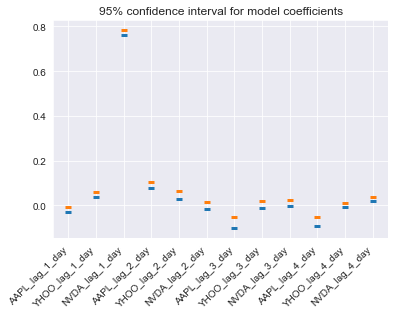

In [17]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3);
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3);
ax.set(title='95% confidence interval for model coefficients');
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

### Visualizing model score variability over time
Now that you've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the ```TimeSeriesSplit``` object will use successively-later indices for each test set. This means that you can treat the scores of your validation as a time series. You can visualize this over time in order to see how the model's performance changes over time.

In [18]:
def my_pearsonr(est, X, y):
    # Generate predictions and convert to a vector
    y_pred = est.predict(X).squeeze()

    # Use the numpy "corrcoef" function to calculate a correlation matrix
    my_corrcoef_matrix = np.corrcoef(y_pred, y.squeeze())

    # Return a single correlation value from the matrix
    my_corrcoef = my_corrcoef_matrix[1, 0]
    return my_corrcoef

In [19]:
from sklearn.model_selection import cross_val_score
from functools import partial

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

C:\Users\dghr201\AppData\Local\Temp\ipykernel_39244\1687367918.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = data[:, np.newaxis]


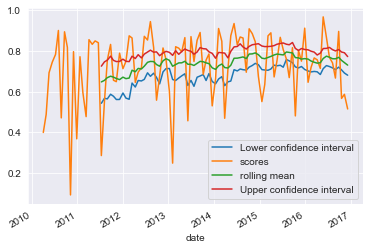

In [20]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label='Lower confidence interval');
scores_series.plot(ax=ax, label='scores')
scores_series.rolling(20).mean().plot(ax=ax, label='rolling mean')
scores_hi.plot(ax=ax, label='Upper confidence interval');
ax.legend();

### Accounting for non-stationarity
In this exercise, you will again visualize the variations in model scores, but now for data that changes its statistics over time.

In [21]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)

    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

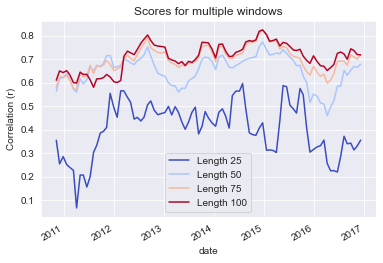

In [22]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm);
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)');

## Wrap-up
- Timeseries and machine learning
    - Many applications of time series + machine learning
    - Always visualize your data first
- Feature extraction and classification
    - Summary statistics for time series classification
    - Combining multiple features into a single input matrix
    - Feature extraction for time series data
- Model fitting and improving data quality
    - Time series features for regression
    - Generating predictions over time
    - Cleaning and improving time series data
- Validating and assessing our model performance
    - Cross-validation with time series data (don't shuffle the data!)
    - Time series stationary
    - Assessing model coefficient and score stability
- Advanced concepts in time series
    - Advanced window functions
    - Signal processing and filtering details
    - Spectral Analysis
- Advanced machine learning
    - Advanced time series feature extraction (e.g., ```tsfresh```)
    - More complex model architectures for regression and classification
    - Production-ready pipelines for time series analysis
